# Fix Amplitude of Angular CF

There was a [bug reported](https://github.com/steven-murray/halomod/issues/63) that AngularCF is returning really large values for the tracer correlation function, specifically for v1.6.0 of `halomod`. This notebook tries to find out why, and fix it.

In [1]:
from halomod import AngularCF
import halomod

In [2]:
halomod.__version__

'1.6.1.dev3+ge514be1.d20200819'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## The problem illustrated

We will try to roughly reproduce the results of Blake+2008:

<img src="blake-angular-cf.png">

In [4]:
acf = AngularCF(z=0.475, zmin=0.45, zmax=0.5)

0.020985469830531824 200.8477374474284


Text(0, 0.5, 'Angular CF')

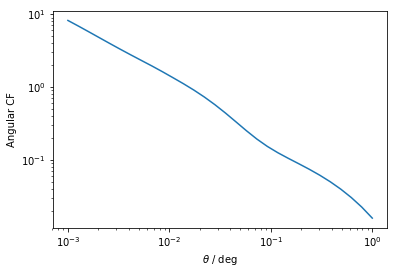

In [5]:
plt.plot(acf.theta * 180/np.pi, acf.angular_corr_gal)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\theta$ / deg")
plt.ylabel('Angular CF')

Note that this is pretty much 1000x times what Blake+ got, but does have a similar shape.

Let's go a bit deeper and look at the exact parameters used in Blake+:

<img src="blake-parameters.png">

In [6]:
acf.mean_tracer_den * 1e4

177.77263912960598

OK, this is awful. Let's try specify the HOD more accurately:

In [7]:
acf.hod_model = 'Zheng05'
acf.hod_params = {'M_min': 12.98, 'M_0':-10, 'M_1':14.09, 'sig_logm':0.21, 'alpha':1.57}

In [8]:
acf.mean_tracer_den * 1e4, acf.bias_effective_tracer, acf.mass_effective

(4.979639982661926, 1.9902140044472905, 13.594144870424108)

This is *much* closer. Now let's try the ACF:

0.020985469830531824 200.8477374474284


Text(0, 0.5, 'Angular CF')

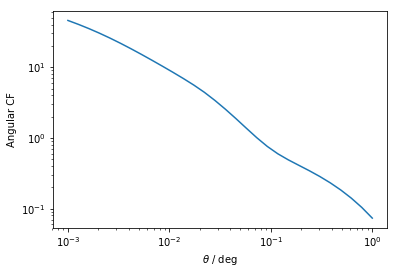

In [9]:
plt.plot(acf.theta * 180/np.pi, acf.angular_corr_gal)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\theta$ / deg")
plt.ylabel('Angular CF')

It's even worse than before!

Let's plot the standard correlation function:

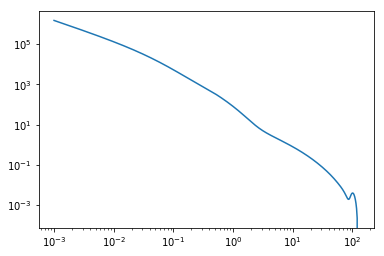

In [24]:
r = np.logspace(-3, 2.1, 500)
plt.plot(r, acf.corr_auto_tracer_fnc(r))
plt.xscale('log')
plt.yscale('log')

This is of a similar magnitude to that found in Blake. 

## Try using low-level angular_corr_gal

In [22]:
from halomod.integrate_corr import angular_corr_gal

In [36]:
angular_corr_gal(
    theta=np.array([1e-3]), 
    xi = acf.corr_auto_tracer_fnc, 
    p1=lambda x : 0.7*np.ones_like(x)/(Planck15.comoving_distance(0.5).value - Planck15.comoving_distance(0.45).value),
    p_of_z=False,
    zmin=0.45, 
    zmax=0.5, 
    logu_min=-6, 
    logu_max=2.1,
    unum=1000,
    znum=500
)

1.2023652010137391 125.89943941984659


array([1.37642816])

In [30]:
from astropy.cosmology import Planck15

In [31]:
Planck15.comoving_distance(0.45)

<Quantity 1774.97077209 Mpc>

In [32]:
Planck15.comoving_distance(0.5)

<Quantity 1945.56129691 Mpc>

In [10]:
np.linspace(0,1,2)

array([0., 1.])